In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

/home/bender/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Лабораторная работа 2. Композиции алгоритмов. Ранжирование.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_02.ipynb.

## Bias-Variance decomposition. Композиции алгоритмов

![](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

Рассмотрим задачу регрессии со среднеквадратичной функцией потерь, а также некоторый алгорим $a$. Тогда качество алгоритма $a$ может быть записано следующим образом:

$$Q(a) = \mathbb{E}_{X^l} \mathbb{E}_{x,y}(a(x) - y)^2$$

где первое матожидание вычисляется по всевозможным обучающим выборкам $X^l$. К сожалению, на реальных данных эта формула неприменима из-за невозможности сгенерировать необходимые для оценки данные. Поэтому проведем приближенный численный эксперимент с эмпирическими оценками матожиданий.

Обозначим вектор истинных меток тестовой выборки за $y \in \mathbb{R}^{l}$. С помощью бутстраппинга можно просемплировать из обучающей выборки $N$ новых выборок того же размера, тем самым "имитируя" пространство всевозможных обучающих выборок, после чего обучить на каждой выбранный алгоритм. Векторы прогнозов для объектов из тестовой выборки для каждой модели обозначим за $\hat{y}_i \in \mathbb{R}^{l}, i \in \{1, .., N\}$. Тогда средний квадрат ошибки по всем моделям на тестовой выборке запишется как

$$error=\frac{1}{N}\sum_{i=1}^{N}MSE(y,\hat{y}_i)$$

Обозначим среднее предсказание за $$\overline{y} = \frac{1}{N}\sum_{i=1}^{N} \hat{y}_i$$

Тогда квадрат отклонения среднего предсказания и разброс прогнозов относительно среднего предсказания всех моделей на тестовой выборке от истинных меток запишутся следующим образом, соответственно:

$$bias^2 = MSE(y, \overline y)$$

$$variance = \frac{1}{N}\sum_{i=1}^N MSE(\hat{y}_i, \overline y)$$


Для начала рассмотрим в качестве алгоритма решающее дерево. Как известно, при увеличении высоты дерева алгоритм может быть сильно чувствителен к составу обучающей выборки. Чтобы подтвердить эти предположения, проведите следующие эксперименты.

Загрузите [набор данных](http://archive.ics.uci.edu/ml/datasets/BlogFeedback). Каждый объект — пост в блоге. Он описывается различными признаками: длина текста поста, наличие наиболее частотных слов, день недели, количество комментариев за последние 24 часа и т.п., а так же целевым признаком — количеством комментариев к посту. Полный список признаков и описание находятся на странице датасета. 

Разбейте данные из файла **blogData_train.csv** на обучающую и тестовую выборки в пропорциях 1 к 4 соответственно. Обратите внимание, что обучающая выборка меньше тестовой. Такая большая тестовая выборка позволит сделать измерение качества моделей достаточно достоверным. 

In [19]:
data = pd.read_csv("blogData_train.csv", header=None)

In [20]:
data.shape

(52397, 281)

In [26]:
data[:5]

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,40.30467,53.845657,0,401,15,15.52416,32.44188,0,377,3,...,0,1,0,0,0,0,0,0,0,1
1,40.30467,53.845657,0,401,15,15.52416,32.44188,0,377,3,...,1,0,0,0,0,0,0,0,0,0
2,40.30467,53.845657,0,401,15,15.52416,32.44188,0,377,3,...,1,0,0,0,0,0,0,0,0,0
3,40.30467,53.845657,0,401,15,15.52416,32.44188,0,377,3,...,0,1,0,0,0,0,0,0,0,1
4,40.30467,53.845657,0,401,15,15.52416,32.44188,0,377,3,...,0,1,0,0,0,0,0,0,0,27


In [46]:
X = data.iloc[:, :280]
Y = data.iloc[:, 280]

In [50]:
print X.shape
print Y.shape

(52397, 280)
(52397,)


In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=666)

In [53]:
print X_train.shape, Y_train.shape
print X_test.shape, Y_test.shape

(10479, 280) (10479,)
(41918, 280) (41918,)


**(1 балл)** Постройте графики зависимости $error$, $bias^2$ и $variance$ от глубины решающего дерева (от 1 до 15 включительно) для $N=100$. 

In [189]:
N = 100

def compute_y_bootstrap(N, depth, X_train, Y_train, X_test):
    Y_matr = np.zeros((N, X_test.shape[0]))
    for n in range(N):
        train_size = X_train.shape[0]
        train_indices = np.random.choice(train_size, size=train_size)
        X_train_boot = X_train.iloc[train_indices]
        Y_train_boot = Y_train.iloc[train_indices]
        clf = DecisionTreeRegressor(max_depth = depth)
        clf.fit(X_train_boot, Y_train_boot)
        Y_pred = clf.predict(X_test)
        Y_matr[n] = Y_pred
    return Y_matr


def compute_error(Y_matr, Y_true):
    mse = np.zeros(Y_matr.shape[0])
    for i in range(Y_matr.shape[0]):
        mse[i] = mean_squared_error(Y_true, Y_matr[i])
    return mse.mean()

In [170]:
error_list = []
bias_list = []
variance_list = []
for depth in range(1, 16):
    print 'depth = ', depth
    Y_matr = compute_y_bootstrap(100, depth, X_train, Y_train, X_test)
    error_list.append(compute_error(Y_matr, Y_test))
    Y_mean = Y_matr.mean(axis = 0)
    bias_list.append(mean_squared_error(Y_test, Y_mean))
    variance_list.append(compute_error(Y_matr, Y_mean))

depth =  1
depth =  2
depth =  3
depth =  4
depth =  5
depth =  6
depth =  7
depth =  8
depth =  9
depth =  10
depth =  11
depth =  12
depth =  13
depth =  14
depth =  15


In [173]:
def plot(X, Y, title, x_label='x', y_label='y', fig_size=(14, 8)):
    plt.figure(figsize=fig_size)
    plt.plot(X, Y)
    plt.title(title, size=20)
    plt.xlabel(x_label, size=15)
    plt.ylabel(y_label, size=15)
    plt.show()

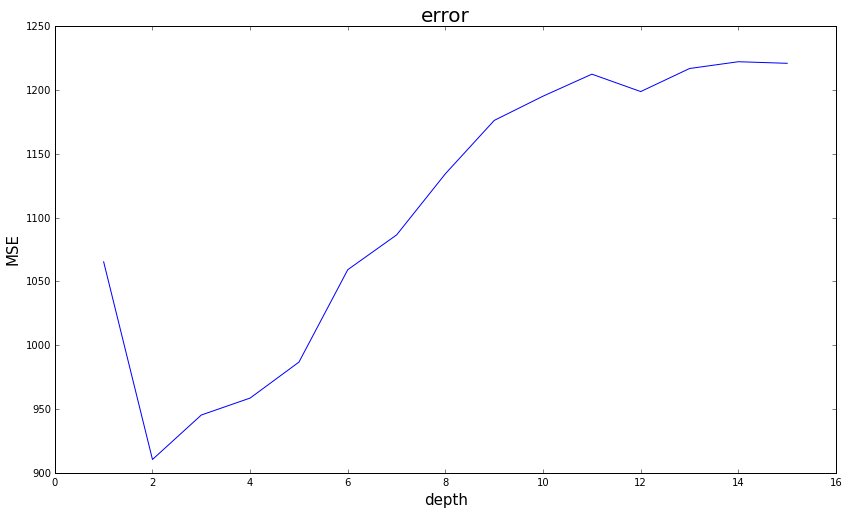

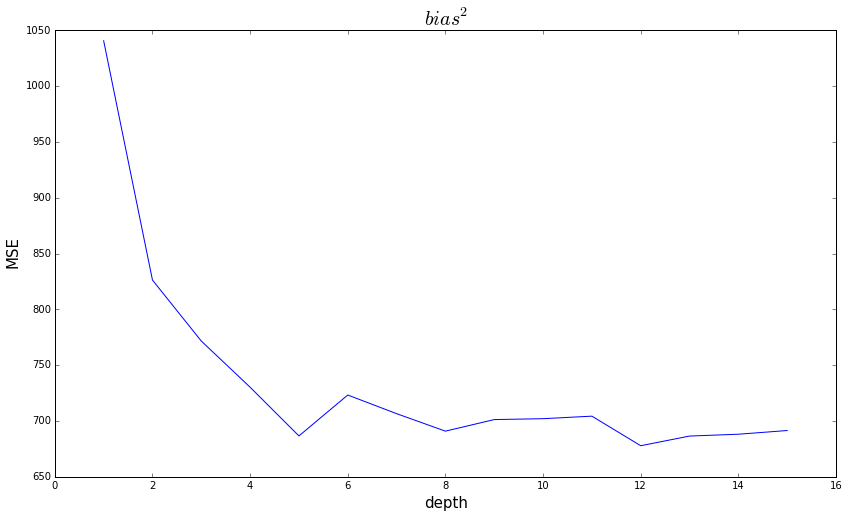

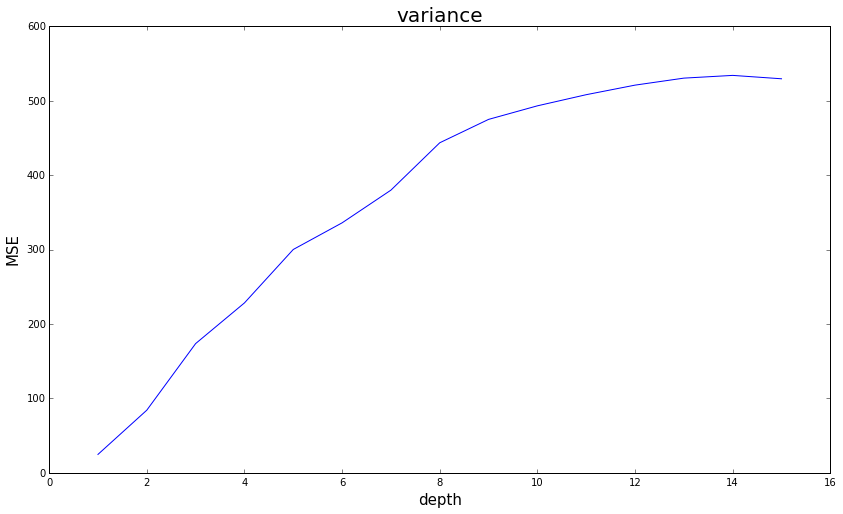

In [174]:
X = list(range(1, 16))
plot(X, error_list, 'error', 'depth', 'MSE')
plot(X, bias_list, '$bias^2$', 'depth', 'MSE')
plot(X, variance_list, 'variance', 'depth', 'MSE')

**(1 балл)** Являются ли какие-то из полученных графиков монотонными? А должны ли они быть монотонными, если бы гипотетически эксперименты были проведены на всевозможных выборках? Почему? Убедитесь численно, что верно bias-variance разложение ошибки: $$error = bias^2 + variance$$

Ни один из полученных графиков не является монотонным. График $variance$ почти монотонно возрастает, но все-таки в конце (с 14 на 15) убывает. Но на самом деле графики $bias^2$ и $variance$ должны быть монотонными, если бы эксперименты были проведены на всевозможных выборках, потому что с усложнением модели $bias^2$ должен все время убывать, а $variance$ - возрастать.

In [183]:
for i, elem in enumerate(error_list):
    #print elem, bias_list[i] + variance_list[i]
    if abs(elem - bias_list[i] - variance_list[i]) < 0.001:
        print 'true'
    else:
        print 'false'

true
true
true
true
true
true
true
true
true
true
true
true
true
true
true


Видим, что bias-variance разложение ошибки верно.

## Композиции алгоритмов

Несмотря на описанный выше недостаток решающих деревьев, объединение их в композиции позволяет существенно улучшить качество предсказания. Рассмотрим несколько способов построения композиций.

### Bagging + RSM

![](https://sites.google.com/site/rajhansgondane2506/_/rsrc/1467898300734/publications/rrftrain.jpg?height=215&width=320)

Один из способов объединения алгоритмов в композиции — обучение каждого отдельного алгоритма на некоторой подвыборке из исходной выборки ([bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating)) и подмножестве исходных признаков ([RSM](https://en.wikipedia.org/wiki/Random_subspace_method)). В sklearn этот тип композиции реализован в классе [BaggingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) (для случая регресии). Подобный подход также есть в реализации [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

### Градиентный бустинг

В случае бустинга композиция алгоритмов строится последовательно. Каждый следующий базовый алгоритм акцентируется на тех объектах, на которых обученная ранее композиция допускала ошибку.

На данный момент одной из самых широко распространенных реализаций бустинга является библиотека [XGBoost](https://github.com/dmlc/xgboost). В ней большое внимание уделяется регуляризации и скорости, нежели в других реализациях бустинга (например,  [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) из sklearn). Кроме того, XGBoost позволяет оптимизировать различные функции потерь, а также более гибок, засчет большого числа параметров.

XGBoost строит композицию из $K$ базовых алгоритмов $b_k$:

$$ \hat{y}_i = \hat{y}_i^{K} = \sum_{k=1}^{K} b_k(x_i) = \hat{y}_i^{\left(K - 1\right)} + b_K(x_i), $$

минимизируя следующий функционал:

$$ Obj = \sum_{i=1}^N \mathcal{L}(y_i, \hat{y}_i ) + \sum_{k=1}^{K} \Omega(b_k),$$

где
 - $N$ — размер обучающей выборки;
 - $x_i, y_i, \hat{y}_i$ — i-ый объект, правильный ответ и предсказание модели для него;
 - $\hat{y}_i^{t}$ — предсказание композиции из $t$ уже обученных базовых алгоритмов для i-го объекта;
 - $\Omega$ — регуляризатор;
 - $\mathcal{L}(y_i, \hat{y}_i)$ — функция потерь.

Функционал, оптимизируемый на $t$-ой итерации:

$$ Obj^{(t)} = \sum_{i=1}^N \mathcal{L}\left(y_i, \hat{y}_i^{(t-1)} + b_t(x_i)\right) + \Omega(b_t).$$

В случае бустинга над решающими деревьями регуляризатор имеет следующий вид:

$$ \Omega(b_t) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2 + \alpha\sum_{j=1}^{T}w_j,$$

где 
 - $T$ — количество листьев в дереве;
 - $w_j$ — веса в листьях дерева;
 - $\lambda, \alpha, \gamma$ — гиперпараметры.

Данный регуляризатор подобран эвристически и хорошо показывает себя на практике. 

Раскладывая в ряд Тейлора выражение $\mathcal{L}\left(y_i, \hat{y}_i^{\left(t-1\right)} + b_t(x_i)\right)$ до второго порядка, получаем:

$$ Obj^{(t)} = \sum_{i=1}^N\left[\mathcal{L}(y_i, \hat{y}_i^{\left(t-1\right)}) + g_{i}b_{t}(x_i) + \frac{1}{2}h_{i}b_{t}^2(x_i)\right] + \Omega(b_t),$$

где $g_i = \partial_{\hat{y}_i^{(t-1)}} \mathcal{L}(y_i, \hat{y_i}^{(t-1)})$, $h_i = \partial_{\hat{y}_i^{(t-1)}}^2 \mathcal{L}(y_i, \hat{y}_i^{(t-1)}) $ — градиент и гессиан оптимизируемой функции потерь.

Приводя теперь подобные слагаемые и отбрасывая слагаемое $ \mathcal{L}(y_i, \hat{y}_i^{(t-1)}) $, не зависящее от $ b_t(x_i)$ (а следовательно, не влияющее на точку минимума функционала), получаем формулу:
$$ Obj^{(t)} \simeq \sum_{j=1}^{T}\left[\sum_{i \in I_j} g_i w_j + \frac{1}{2}\sum_{i \in I_j} (h_i + \lambda)w_j^2\right] + \gamma T$$
$$ = \sum_{j=1}^{T}\left[G_jw_j + \frac{1}{2}(H_j + \lambda)w_j^2\right] + \gamma T, $$

где 
 - $ I_j $ - множество объектов обучающей выборки, попавших в $j$-ый лист дерева;
 - $ G_j = \sum_{i \in I_j} g_i$;
 - $ H_j = \sum_{i \in I_j} h_i$.
 
Теперь, имея заданную структуру дерева, можно аналитически вычислить оптимальные значения для весов:
$$ w_j^* = -\frac{G_j}{H_j + \lambda}.$$

Значение функционала при этом будет равно:

$$ Obj = -\frac{1}{2}\sum_{j=1}^T \frac{G_j^2}{H_j + \lambda} + \gamma T .$$

Осталось только построить дерево оптимальной структуры. Это можно делать известными методами построения решающих деревьев, проводя разбиения таким образом, чтобы максимизировать gain, определенный как уменьшение $Obj$ в момент этого разбиения. Для уже построенного дерева по формулам $ w_j^* $ вычисляются оптимальные значения в листьях.

В XGBoost реализовано несколько различных функций потерь, что позволяет решать задачи классификации (бинарной и мультиклассовой), регрессии и ранжирования. Вот некоторые из них:

- reg:linear — линейная регрессия
- reg:logistic — логистическая регрессия
- binary:logistic — логистическая регрессия
- multi:softmax — softmax функция потерь для многоклассовой классификации
- rank:pairwise — минимизация pairwise-функции потерь для задачи ранжирования

**(1 балл)** Проведите аналогичный эксперимент с bias-variance разложением для градиентного бустинга для количество алгоритмов 1, 5, 10, 25 и 50, используя в качестве базовых алгоритмов решающие деревья. Пример использования библиотеки можно найти в туториале с [семинара про XGBoost](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/b1lm8e763tsxly5/xgboost_tutorial.ipynb). Обратите внимание, что данная библиотека имеет два интерфейса (стандартный и аналог sklearn), названия параметров в которых могут отличаться.

In [190]:
def compute_y_bootstrap(N, clf, X_train, Y_train, X_test):
    Y_matr = np.zeros((N, X_test.shape[0]))
    for n in range(N):
        train_size = X_train.shape[0]
        train_indices = np.random.choice(train_size, size=train_size)
        X_train_boot = X_train.iloc[train_indices]
        Y_train_boot = Y_train.iloc[train_indices]
        clf.fit(X_train_boot, Y_train_boot)
        Y_pred = clf.predict(X_test)
        Y_matr[n] = Y_pred
    return Y_matr

In [191]:
error_list_xgb = []
bias_list_xgb = []
variance_list_xgb = []
for num_estimators in [1, 5, 10, 25, 50]:
    print 'number of estimators = ', num_estimators
    Y_matr = compute_y_bootstrap(N, xgb.XGBRegressor(n_estimators=num_estimators), X_train, Y_train, X_test)
    error_list_xgb.append(compute_error(Y_matr, Y_test))
    Y_mean = Y_matr.mean(axis = 0)
    bias_list_xgb.append(mean_squared_error(Y_test, Y_mean))
    variance_list_xgb.append(compute_error(Y_matr, Y_mean))

number of estimators =  1
number of estimators =  5
number of estimators =  10
number of estimators =  25
number of estimators =  50


In [197]:
error_list_xgb

[1264.4023255963211,
 952.70955021505642,
 786.46910585516741,
 686.50385992452925,
 689.05636373845573]

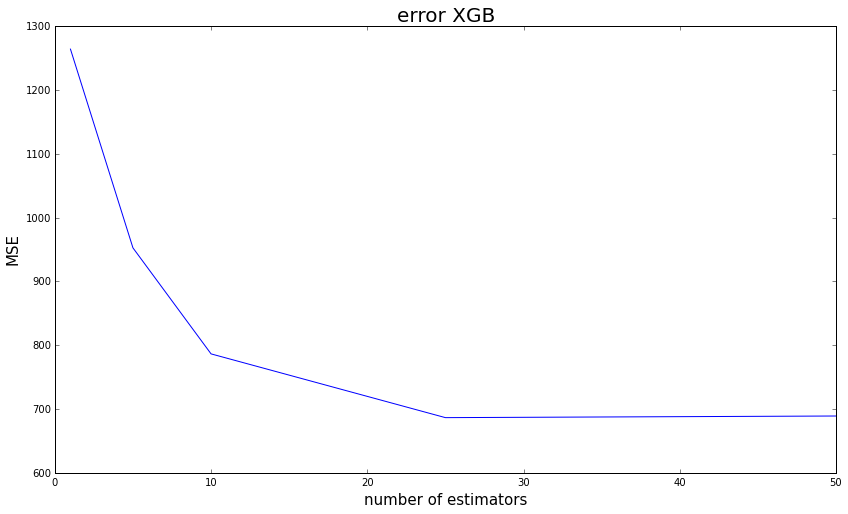

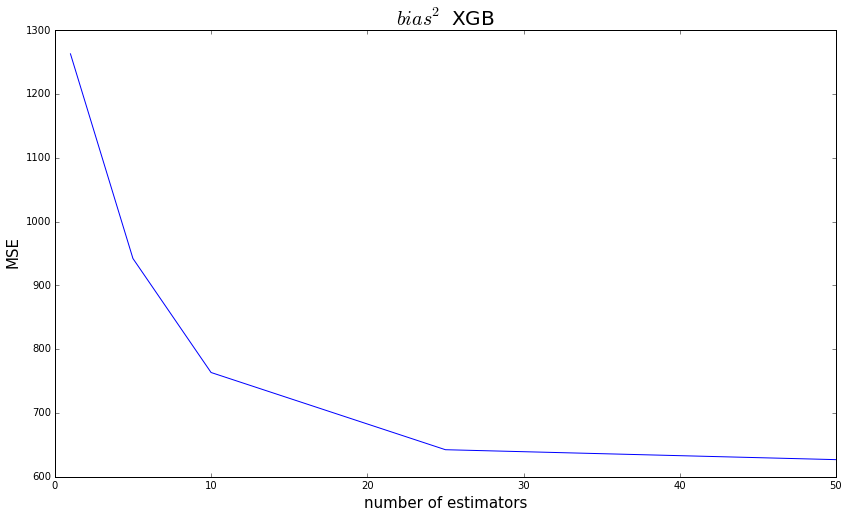

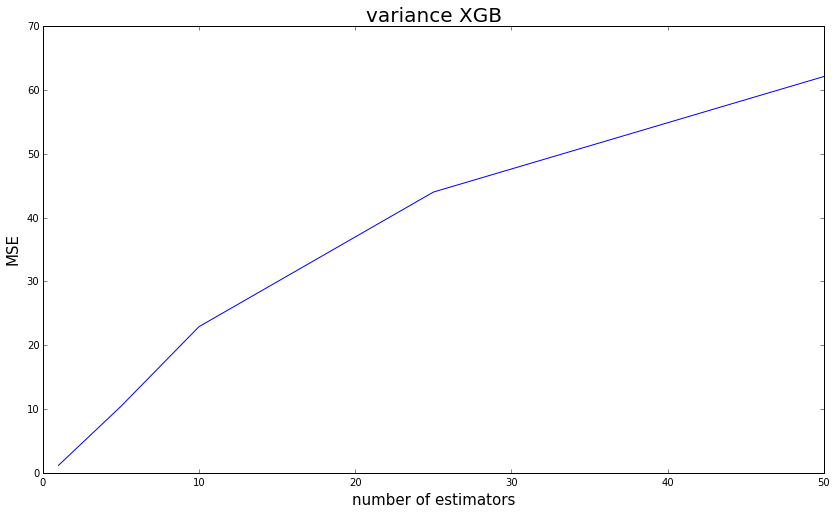

In [198]:
X = [1, 5, 10, 25, 50]
plot(X, error_list_xgb, 'error XGB', 'number of estimators', 'MSE')
plot(X, bias_list_xgb, '$bias^2$ XGB', 'number of estimators', 'MSE')
plot(X, variance_list_xgb, 'variance XGB', 'number of estimators', 'MSE')

**(0.5 балла)** Отличаются ли графики в рассмотренных моделях (решающее дерево, градиентный бустинг на решающих деревьях)  между собой? На какую компоненту из разложения ошибки влияет объединение алгоритмов в рассмотренный тип композиции?

Графики в рассмотренных моделях отличаются. В первой модели (решающее дерево) графики $bias^2$ и $variance$ получились немонотонными, а во второй (градиентный бустинг) - монотонными.

Рассмотренный тип композиции влияет на компоненту $bias^2$.

## Поисковое ранжирование

![](http://i.imgur.com/2QnD2nF.jpg)

Задачу поискового ранжирования можно описать следующим образом: имеется множество документов $d \in D$ и множество запросов $q \in Q$. Требуется оценить *степень релевантности* документа по отношению к запросу: $(q, d) \mapsto r$, относительно которой будет производиться ранжирование. Для восстановления этой зависимости используются методы машинного обучения. Обычно используется три типа:
 - признаки запроса $q$, например: мешок слов текста запроса, его длина, ...
 - документа $d$, например: значение PageRank, мешок слов, доменное имя, ...
 - пары $(q, d)$, например: число вхождений фразы из запроса $q$ в документе $d$, ...

Одна из отличительных особенностей задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса, т.е. важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно других документов.

### Оценка качества

Для оценивания качества ранжирования найденных документов в поиске используются асессорские оценки. Само оценивание происходит на скрытых от обучения запросах $Queries$. Для этого традиционно используется метрика *DCG* ([Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)) и ее нормализованный вариант — *nDCG*, всегда принимающий значения от 0 до 1.
Для одного запроса DCG считается следующим образом:
$$ DCG = \sum_{i=1}^P\frac{(2^{rel_i} - 1)}{\log_2(i+1)}, $$

где $P$ — число документов в поисковой выдаче, $rel_i$ — релевантность (асессорская оценка) документа, находящегося на i-той позиции.

*IDCG* — идеальное (наибольшее из возможных) значение *DCG*, может быть получено путем ранжирования документов по убыванию асессорских оценок.

Итоговая формула для расчета *nDCG*:

$$nDCG = \frac{DCG}{IDCG} \in [0, 1].$$

Чтобы оценить значение *nDCG* на выборке $Queries$ ($nDCG_{Queries}$) размера $N$, необходимо усреднить значение *nDCG* по всем запросам  выборки:
$$nDCG_{Queries} = \frac{1}{N}\sum_{q \in Queries}nDCG(q).$$

Пример реализации метрик ранжирование на python можно найти [здесь](https://gist.github.com/mblondel/7337391).

Загрузите данные конкурса [Интернет-математика 2009](http://imat2009.yandex.ru/datasets). Там же находится описание данных. Разбейте обучающую выборку на обучение и контроль в соотношении 70 / 30. Обратите внимание на формат данных: разбивать необходимо множество запросов, а не строчки датасета.

In [4]:
f = open('imat2009_learning.txt')
data_imat = []
for line in f:
    data_imat.append(line)
f.close()

In [2]:
def read_data(input_file):
    f = open(input_file)
    data_imat = []
    for i, line in enumerate(f):
        if i%10000 == 0:
            print i
        features = dict(re.findall(r'(\d*)\:(\d*\.\d*)', line))
        for key, val in features.items():
            features[key] = float(val)
        queryid = int(re.findall(r'#\ (\d*)', line)[0])
        features['queryid'] = queryid
        features['relevance'] = int(line[0])
        data_imat.append(features)
    f.close()
    result = pd.DataFrame(data_imat)
    return result


def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------
    DCG @k : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    """Normalized discounted cumulative gain (NDCG) at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------
    NDCG @k : float
    """
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual / best

In [3]:
df = read_data('imat2009_learning.txt')

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [4]:
df.fillna(0, inplace=True)

In [5]:
df[5:10]

,1,10,100,101,102,103,104,105,106,107,...,92,93,94,95,96,97,98,99,queryid,relevance
5,0.000000,0.000000,0.999999,0.000000,1,1.000000,1,0.411765,0,0,...,1.00000,1,0.000000,0.027451,0,0.000000,0.131557,0,3382,1
6,0.000000,0.000000,0.000000,0.000000,1,0.894118,1,0.756863,0,0,...,0.00000,1,0.000000,0.023529,0,0.000000,0.139158,0,3382,1
7,0.000620,0.009007,0.016971,0.011530,1,1.000000,0,0.847059,0,0,...,0.87425,1,0.605714,0.007843,0,0.000027,0.500000,0,11800,1
8,0.000037,0.000000,0.267807,0.000000,1,0.000000,0,0.176471,0,0,...,0.89091,0,0.111111,0.015686,0,0.000000,0.000000,0,11800,0
9,0.000000,0.000000,0.000000,0.009167,1,0.086274,0,0.803922,0,0,...,0.00000,0,0.000000,0.035294,0,0.000000,0.000000,0,11800,0


In [6]:
query_ids = list(set(df.queryid))
query_number = len(query_ids)

In [7]:
train_indices, test_indices = train_test_split(query_ids, test_size=0.3, random_state=666)

In [8]:
data_train = df[df.queryid.isin(train_indices)]
data_test = df[df.queryid.isin(test_indices)]

In [9]:
X_train = data_train.iloc[:, :-2]
Y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-2]
Y_test = data_test.iloc[:, -1]

Далее рассмотрим несколько подходов предсказания релевантности. Для оценивания качества моделей используйте метрику nDCG на контроле. В случае подбора гиперпараметров используйте кросс-валидацию по 5 блокам.

**(1 балл)** [Point-wise](https://en.wikipedia.org/wiki/Learning_to_rank#Pointwise_approach) подход. В этом случае значение функции потерь определяется по одному объекту, например, как в случае регрессии. Воспользовавшись известными вам техниками построения линейной регрессии, обучите модель, предсказывающую оценку асессора.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [16]:
clf_linear = LinearRegression()
clf_linear.fit(X_train, Y_train)
y_pred = clf_linear.predict(X_test)

In [93]:
clf_linear2 = Ridge(alpha=0.1)
clf_linear2.fit(X_train, Y_train)
y_pred2 = clf_linear2.predict(X_test)

In [12]:
def compute_ndcg_queries(true_data, y_pred):
    """true_data - dataframe with 2 columns: 1. queryid, 2. relevance
    returns mean ndcg of all queries
    """
    ngcd_queries = []
    true_data['pred'] = y_pred
    for queryid in set(true_data.queryid):
        temp_df = true_data[true_data.queryid == queryid]
        ngcd_queries.append(ndcg_score(list(temp_df.relevance), list(temp_df.pred)))
    return np.mean([x for x in ngcd_queries if pd.notnull(x)])

In [77]:
point_wise_ndcg = compute_ndcg_queries(data_test.iloc[:, -2:], y_pred)

In [78]:
point_wise_ndcg

0.80264946652669245

In [94]:
point_wise_ndcg2 = compute_ndcg_queries(data_test.iloc[:, -2:], y_pred2)

In [92]:
point_wise_ndcg2

0.80269833004326119

**(1 балл)** [Pair-wise](https://en.wikipedia.org/wiki/Learning_to_rank#Pairwise_approach) подход. Здесь функция потерь вычисляется по паре объектов. Постройте ранжирующую модель при помощи [SVMlight](http://www.cs.cornell.edu/people/tj/svm_light/svm_rank.html), реализующий [Ranking SVM](https://en.wikipedia.org/wiki/Ranking_SVM).

###  Ранжируем с XGBoost

XGBoost имеет несколько функций потерь для решения задачи ранжирования:
1. **reg:linear** — эта функция потерь нужна для решения задачи регрессии, тем не менее, ее можно использовать в качестве ранжирующей point-wise модели.
2. **rank:pairwise** — в качестве pairwise модели в XGBoost реализован [RankNet](http://research.microsoft.com/en-us/um/people/cburges/papers/ICML_ranking.pdf), в котором минимизируется гладкий функционал качества ранжирования: $$ Obj = \sum_{i \prec j} \mathcal{L}\left(a(x_j) - a(x_i)\right) \rightarrow min $$ $$ \mathcal{L}(M) = log(1 + e^{-M}), $$ где $ a(x) $ - функция ранжирования. Суммирование ведется по всем парам объектов, для которых определено отношение порядка, например, для пар документов, показанных по одному запросу. Таким образом функция потерь штрафует за то, что пара объектов неправильно упорядочена.
3. **rank:map, rank:ndcg** — реализация [LambdaRank](http://research.microsoft.com/en-us/um/people/cburges/papers/lambdarank.pdf) для двух метрик: [MAP](https://www.kaggle.com/wiki/MeanAveragePrecision) и **nDCG**. Известно, что для того, чтобы оптимизировать негладкий функционал, такой как **nDCG**,  нужно домножить градиент функционала $ Obj(a) $ на значение $\Delta NDCG_{ij} $ — изменение значения функционала качества при замене $x_i$ на $ x_j$.  Поскольку для вычисления метрик необходимы все объекты выборки, то эти две ранжирующие функции потерь являются представителями класса [list-wise](https://en.wikipedia.org/wiki/Learning_to_rank#Listwise_approach) моделей.

**(1 балл)** Обучите модели **rank:pairwise** и **rank:ndcg**, в качестве метрики оценки качества (*eval_metric*) используя *nDCG*, а в качестве бустера решающее дерево. Рассмотрите различные [параметры](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md) бустера: *eta*, *gamma*, *tree_method*. Какие параметры сильнее всего влияют на качество?

In [34]:
def get_params():
    params = {}
    params["objective"] = "rank:pairwise"
    params["booster"] = "gbtree"
    params["eval_metric"] = "ndcg"
    return params

In [13]:
params = get_params()
xgtrain = xgb.DMatrix(X_train.as_matrix(), label=Y_train.as_matrix())

In [13]:
xgtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix())
bst = xgb.train(params, xgtrain)
print "nDCG on rank:pairwise XGBoost (default params) = ", bst.eval(xgtest)

nDCG on rank:pairwise XGBoost (default params) =  [0]	eval-:0.904798


In [15]:
params["objective"] = "rank:ndcg"
xgtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix())
bst = xgb.train(params, xgtrain)
print "nDCG on rank:ndcg XGBoost (default params) = ", bst.eval(xgtest)

nDCG on rank:ndcg XGBoost (default params) =  [0]	eval-:0.837299


Видим, что модель rank:pairwise лучше, чем модель rank:ndcg XGBoost.

Попробуем рассмотреть различные параметры:

### eta

In [21]:
params["objective"] = "rank:pairwise"
for eta in np.arange(0.1, 1, 0.1):
    params['eta'] = eta
    xgtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix())
    bst = xgb.train(params, xgtrain)
    print "nDCG on rank:pairwise XGBoost (eta = %0.1f) = %s" % (eta, bst.eval(xgtest))

nDCG on rank:pairwise XGBoost (eta = 0.1) = [0]	eval-:0.883875
nDCG on rank:pairwise XGBoost (eta = 0.2) = [0]	eval-:0.896196
nDCG on rank:pairwise XGBoost (eta = 0.3) = [0]	eval-:0.904798
nDCG on rank:pairwise XGBoost (eta = 0.4) = [0]	eval-:0.908037
nDCG on rank:pairwise XGBoost (eta = 0.5) = [0]	eval-:0.908829
nDCG on rank:pairwise XGBoost (eta = 0.6) = [0]	eval-:0.903092
nDCG on rank:pairwise XGBoost (eta = 0.7) = [0]	eval-:0.905758
nDCG on rank:pairwise XGBoost (eta = 0.8) = [0]	eval-:0.917743
nDCG on rank:pairwise XGBoost (eta = 0.9) = [0]	eval-:0.915681


In [22]:
params["objective"] = "rank:ndcg"
for eta in np.arange(0.1, 1, 0.1):
    params['eta'] = eta
    xgtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix())
    bst = xgb.train(params, xgtrain)
    print "nDCG on rank:ndcg XGBoost (eta = %0.1f) = %s" % (eta, bst.eval(xgtest))

nDCG on rank:ndcg XGBoost (eta = 0.1) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (eta = 0.2) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (eta = 0.3) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (eta = 0.4) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (eta = 0.5) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (eta = 0.6) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (eta = 0.7) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (eta = 0.8) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (eta = 0.9) = [0]	eval-:0.837299


### gamma

In [35]:
params = get_params()

In [36]:
params["objective"] = "rank:pairwise"
for gamma in [5, 7, 10, 15, 20, 50, 100]:
    params['gamma'] = gamma
    xgtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix())
    bst = xgb.train(params, xgtrain)
    print "nDCG on rank:pairwise XGBoost (gamma = %0.1f) = %s" % (gamma, bst.eval(xgtest))

nDCG on rank:pairwise XGBoost (gamma = 5.0) = [0]	eval-:0.901234
nDCG on rank:pairwise XGBoost (gamma = 7.0) = [0]	eval-:0.905545
nDCG on rank:pairwise XGBoost (gamma = 10.0) = [0]	eval-:0.897880
nDCG on rank:pairwise XGBoost (gamma = 15.0) = [0]	eval-:0.893919
nDCG on rank:pairwise XGBoost (gamma = 20.0) = [0]	eval-:0.896912
nDCG on rank:pairwise XGBoost (gamma = 50.0) = [0]	eval-:0.890988
nDCG on rank:pairwise XGBoost (gamma = 100.0) = [0]	eval-:0.889311


In [37]:
params = get_params()
params["objective"] = "rank:ndcg"
for gamma in [5, 7, 10, 15, 20, 50, 100]:
    params['gamma'] = gamma
    xgtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix())
    bst = xgb.train(params, xgtrain)
    print "nDCG on rank:ndcg XGBoost (gamma = %0.1f) = %s" % (gamma, bst.eval(xgtest))

nDCG on rank:ndcg XGBoost (gamma = 5.0) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (gamma = 7.0) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (gamma = 10.0) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (gamma = 15.0) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (gamma = 20.0) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (gamma = 50.0) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (gamma = 100.0) = [0]	eval-:0.837299


### tree_method

In [27]:
tree_methods = ['auto', 'exact', 'approx']

In [38]:
params = get_params()
params["objective"] = "rank:pairwise"
for method in tree_methods:
    params['tree_method'] = method
    xgtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix())
    bst = xgb.train(params, xgtrain)
    print "nDCG on rank:pairwise XGBoost (method = %s) = %s" % (method, bst.eval(xgtest))

nDCG on rank:pairwise XGBoost (method = auto) = [0]	eval-:0.904798
nDCG on rank:pairwise XGBoost (method = exact) = [0]	eval-:0.904798
nDCG on rank:pairwise XGBoost (method = approx) = [0]	eval-:0.904798


In [39]:
params = get_params()
params["objective"] = "rank:ndcg"
for method in tree_methods:
    params['tree_method'] = method
    xgtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix())
    bst = xgb.train(params, xgtrain)
    print "nDCG on rank:ndcg XGBoost (method = %s) = %s" % (method, bst.eval(xgtest))

nDCG on rank:ndcg XGBoost (method = auto) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (method = exact) = [0]	eval-:0.837299
nDCG on rank:ndcg XGBoost (method = approx) = [0]	eval-:0.837299


В случае модели rank:pairwise сильнее всего влияют на качество параметры: eta и gammma. Параметр tree_method никак не повлиял на качество. 

В случае модели rank:ndcg никакие параметры не повлияли на качество.